## Previsione usando metodi statistici

In [2]:
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.ar_model import AR
import warnings

warnings.filterwarnings('ignore')
data = pd.read_csv('../data/new_data_backfill_forwfill.csv',index_col = 0)

### Test di stazionarietà

<p>Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value ≤ 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.</p>

In [3]:
data.head()

,date,cell_num,nr_people,hours,minutes
0,2017-04-16,486-1252,36.0,0.0,0.0
221,2017-04-16,486-1252,36.0,0.0,15.0
442,2017-04-16,486-1252,34.0,0.0,30.0
663,2017-04-16,486-1252,33.0,0.0,45.0
884,2017-04-16,486-1252,32.0,1.0,0.0


In [4]:
#a = np.array(len(data['date']))
l = []
for i in data['nr_people']:
    l.append(int(i))
    
X = np.asarray(l) 

In [5]:
X = X[0:200000]
result = adfuller(X)

In [6]:
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')

ADF Statistic: -19.711181
p-value: 0.000000
Critical Values:


In [7]:
count = 0
for index, row in data.iterrows():
    print(index, row.date, row.cell_num, row.nr_people)
    count +=1
    if count > 5:
        break

0 2017-04-16 486-1252 36.0
221 2017-04-16 486-1252 36.0
442 2017-04-16 486-1252 34.0
663 2017-04-16 486-1252 33.0
884 2017-04-16 486-1252 32.0
1105 2017-04-16 486-1252 33.0


### Autocorrelation 

<p style="color:black;font-size:16px;">
Because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation.

We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling.  It is also called serial correlation because of the sequenced structure of time series data.
The correlation statistics can also help to choose which lag variables will be useful in a model and which will not. Interestingly, if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable. This can be very useful when getting started on a new dataset.
</p>

In [8]:
group_by_cell = data.groupby(by = data['cell_num'])
count = 0
for i, k in group_by_cell:
    print(i, k)
    count +=1
    if count > 5: 
        break

486-1252                date  cell_num  nr_people  hours  minutes
0        2017-04-16  486-1252       36.0    0.0      0.0
221      2017-04-16  486-1252       36.0    0.0     15.0
442      2017-04-16  486-1252       34.0    0.0     30.0
663      2017-04-16  486-1252       33.0    0.0     45.0
884      2017-04-16  486-1252       32.0    1.0      0.0
...             ...       ...        ...    ...      ...
2608463  2017-08-16  486-1252       41.0   22.0     45.0
2608684  2017-08-16  486-1252       40.0   23.0      0.0
2608905  2017-08-16  486-1252       39.0   23.0     15.0
2609126  2017-08-16  486-1252       40.0   23.0     30.0
2609347  2017-08-16  486-1252       40.0   23.0     45.0

[11808 rows x 5 columns]
486-1253                date  cell_num  nr_people  hours  minutes
1        2017-04-16  486-1253       39.0    0.0      0.0
222      2017-04-16  486-1253       38.0    0.0     15.0
443      2017-04-16  486-1253       36.0    0.0     30.0
664      2017-04-16  486-1253       35.0    

In [9]:
cell = group_by_cell.get_group('486-1252')
series = cell['nr_people'].tolist()
series= series[0:1000]

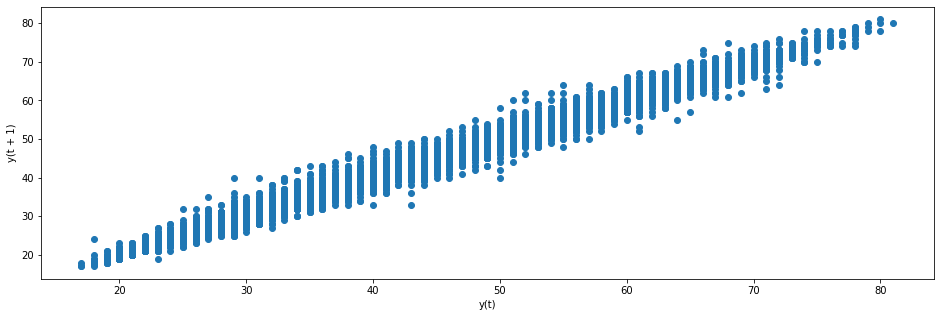

In [10]:
plt.figure(figsize=(16,5))
lag_plot(cell['nr_people'])
plt.show();


In [30]:
# how the t and ist lagged values are correlated
values = pd.DataFrame(cell['nr_people'])
dataframe = pd.concat([values.shift(1), values], axis=1) 
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)
print(dataframe.head())

            t       t+1
t    1.000000  0.993013
t+1  0.993013  1.000000
        t   t+1
0     NaN  36.0
221  36.0  36.0
442  36.0  34.0
663  34.0  33.0
884  33.0  32.0


<p>
We can plot the correlation coefficient for each lag variable. This can very quickly give an idea of which lag variables may be good candidates for use in a predictive model and how the relationship between the observation and its historic values changes over time. 
</p>

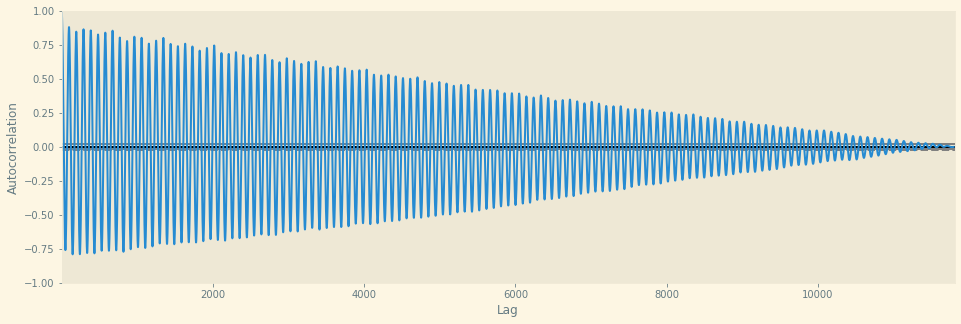

In [31]:
plt.figure(figsize=(16,5))
autocorrelation_plot(values)
plt.show();

<Figure size 1152x360 with 0 Axes>

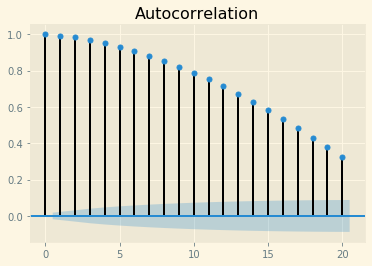

In [32]:
plt.figure(figsize=(16,5))
plot_acf(values, lags=20)
plt.show();

### Persistence model 

Test RMSE: 1.358


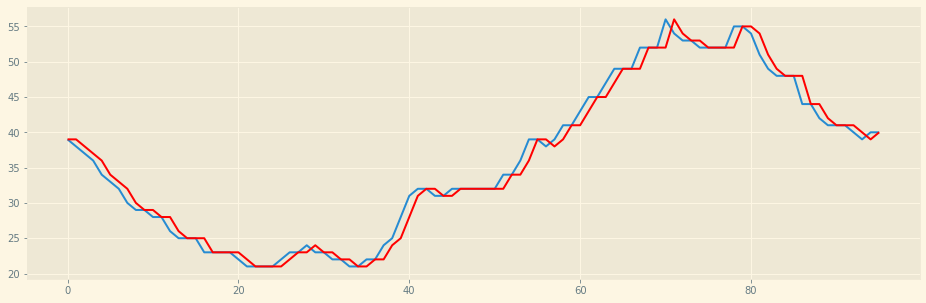

In [33]:
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-96], X[len(X)-96:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
def model_persistence(x):
    return x
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

rmse = sqrt(mean_squared_error(test_y, predictions)) 
print('Test RMSE: %.3f' % rmse)
# plot predictions vs expected
plt.figure(figsize=(16,5))
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

### Autoregression model
<p>
the Statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class
</p>

In [34]:
# split dataset
df = pd.DataFrame(cell['nr_people'])
X= df.values
print(X.shape)
train, test = X[1:len(X)-96], X[len(X)-96:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)
# plot
plt.figure(figsize=(16,5))
pyplot.plot(test)
pyplot.plot(predictions, color='red') 
pyplot.show()

(11808, 1)
predicted=38.742860, expected=39.000000
predicted=38.688694, expected=38.000000
predicted=37.381101, expected=37.000000
predicted=36.221417, expected=36.000000
predicted=35.155108, expected=34.000000
predicted=32.912101, expected=33.000000
predicted=32.098180, expected=32.000000
predicted=31.473343, expected=30.000000
predicted=29.610773, expected=29.000000
predicted=28.900792, expected=29.000000
predicted=28.879563, expected=28.000000
predicted=27.861246, expected=28.000000
predicted=27.894224, expected=26.000000
predicted=25.742074, expected=25.000000
predicted=24.680316, expected=25.000000
predicted=24.799025, expected=25.000000
predicted=24.784233, expected=23.000000
predicted=22.826853, expected=23.000000
predicted=22.697257, expected=23.000000
predicted=22.637677, expected=23.000000
predicted=22.909057, expected=22.000000
predicted=22.151592, expected=21.000000
predicted=21.329289, expected=21.000000
predicted=21.599712, expected=21.000000
predicted=21.675638, expected

NameError: name 'pyplot' is not defined

<Figure size 1152x360 with 0 Axes>

### Autoregressive Integrated Moving Average Model - ARIMA

<p>
ARIMA is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:</p>

<p>1-  AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.</p><br>
<p>2-  I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.</p><br>
3-  MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
</p><br>


#### Parameters of ARIMA

<p>Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.
The parameters of the ARIMA model are defined as follows:    
    
</p>  <br>

<p>p: The number of lag observations included in the model, also called the lag order.</p><br>
<p>d: The number of times that the raw observations are differenced, also called the degree of differencing.</p><br>
<p>q: The size of the moving average window, also called the order of moving average.</p>

#### ARIMA in Python
<p>The Statsmodels library provides the capability to fit an ARIMA model. An ARIMA model can be created using 
   the Statsmodels library as follows:</p> <br>
<p>1. Define the model by calling ARIMA() and passing in the p, d, and q parameters. </p><br>
<p>2. The model is prepared on the training data by calling the fit() function </p><br>
<p>3. Predictions can be made by calling the predict() function3 and specifying the index of
the time or times to be predicted.</p>

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                11807
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -21342.319
Method:                       css-mle   S.D. of innovations              1.475
Date:                Wed, 27 Nov 2019   AIC                          42698.637
Time:                        14:55:48   BIC                          42750.272
Sample:                             1   HQIC                         42715.972
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.032      0.003      0.997      -0.063       0.063
ar.L1.D.y      0.1626      0.009     17.690      0.000       0.145       0.181
ar.L2.D.y      0.1608      0.009     17.328      0.0

<Figure size 1152x360 with 0 Axes>

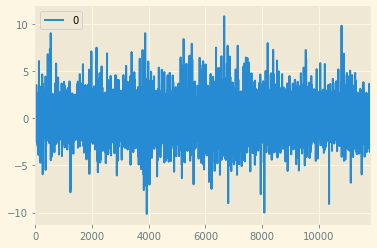

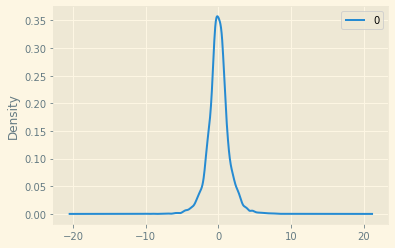

                  0
count  11807.000000
mean       0.000115
std        1.475058
min      -10.136597
25%       -0.745936
50%       -0.024565
75%        0.714459
max       10.794521


In [35]:
# fit an ARIMA model and plot residual errors
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

# fit model
model = ARIMA(X, order=(5,1,0))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())
plt.figure(figsize=(16,5));
# line plot of residuals
residuals = DataFrame(model_fit.resid) 

residuals.plot()
plt.show()
# density plot of residuals 
residuals.plot(kind='kde'); 
plt.show()
# summary stats of residuals
print(residuals.describe())

In [4]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes 
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

NameError: name 'X' is not defined

### Calcolo errore

In [3]:
predictions = np.asarray(predictions)
history = np.asarray(test)
print(predictions.shape, history.shape)
difference = abs(predictions - history[0])
plt.figure(figsize=(16, 3))
plt.boxplot(difference, vert = False);
plt.show()

NameError: name 'predictions' is not defined

#### Exponential Smoothing 

         milk
time         
1962-01   589
1962-02   561
1962-03   640
1962-04   656
1962-05   727


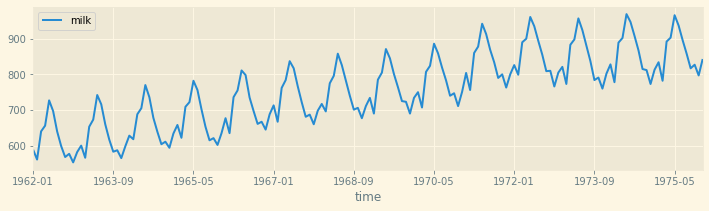

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

plt.style.use('Solarize_Light2')

df = pd.read_csv('milk-production.csv')
df = df.set_index('time')
print(df.head())
train = df.iloc[:-24, :]

test = df.iloc[-24:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3));

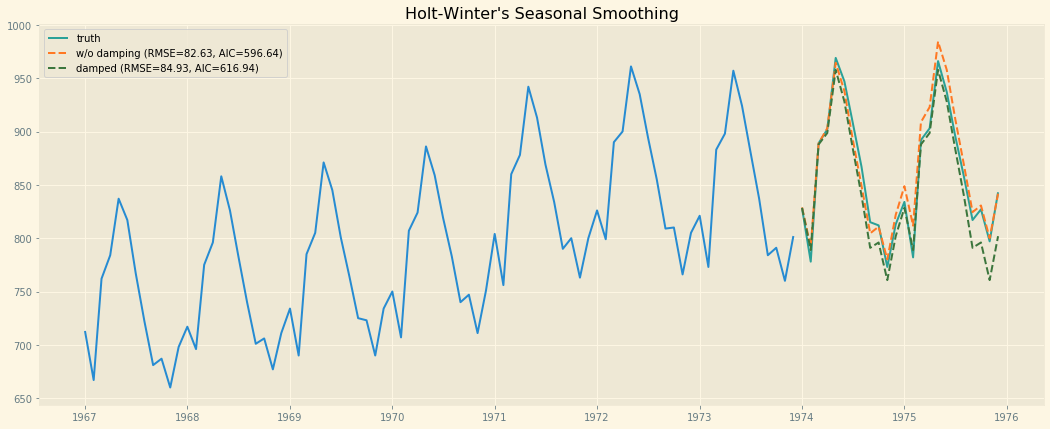

In [38]:
import statsmodels.api as sm
from statsmodels.api import OLS
import numpy as np

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(24)
fit2 = model2.fit()
pred2 = fit2.forecast(24)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

In [19]:
df.head()

,milk
time,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


In [66]:
df = pd.read_csv('cell.csv')
df.head()
df = df[0:700]
df = df.set_index('date')


In [67]:
train = df.iloc[:-200, :]
test = df.iloc[-200:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()

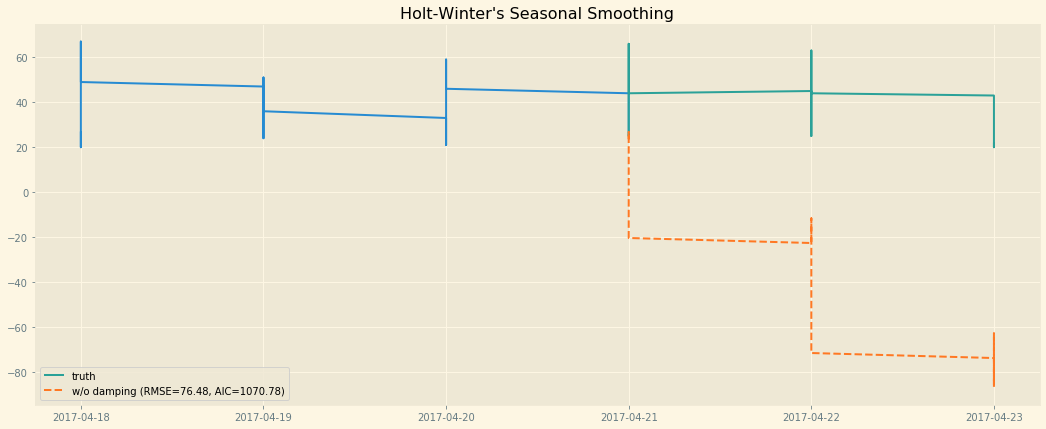

In [68]:
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=24)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=24, damped=True)
fit = model.fit()
pred = fit.forecast(200)
fit2 = model2.fit()
pred2 = fit2.forecast(200)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(train.index[200:], train.values[200:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', 
        label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
#ax.plot(test.index, pred2, linestyle='--', color='#3c763d',
#        label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");